### ライブラリ　インポート

In [1]:
#異常値サンプルを削除した上で目的変数を二値化
#各変数の分布を確認してみる

import numpy as np
import pandas as pd
from pandas import DataFrame  as DF
import matplotlib.pyplot as plt
import seaborn as sns
import math


from scipy import stats

%matplotlib inline

# matplotlibを日本語表示に対応させるモジュール
# !pip install japanize-matplotlib
# import japanize_matplotlib

from sklearn.linear_model import LinearRegression
import statsmodels as sm

from sklearn.model_selection import KFold
from functools import partial
import optuna
from xfeat import SelectCategorical, LabelEncoder, Pipeline,ConcatCombination, SelectNumerical,ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

### データインポート


In [2]:
df = pd.read_csv("input/OnlineNewsPopularity.csv")
df = df.loc[:, "n_tokens_title":]
df


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


### データ確認

In [6]:
#列名取得
col_lst = df.columns
# col_lst

In [7]:
n = 60

print(col_lst[n])
print(df[col_lst[n]].describe())
# print(df["shares"].describe())


X = np.array(df[col_lst[n]])
    # norm_pdf = stats.norm.pdf(x=X, loc=st_lst[0], scale=st_lst[1]) # 期待値=st0, 標準偏差=st1
plt.hist(X, bins=100, color="orange", density=True)

plt.show()

IndexError: index 60 is out of bounds for axis 0 with size 59

### 異常値削除

In [8]:
df

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


In [9]:
col_lst

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negat

In [66]:
# df_arrange = 異常値削除済みDataFrame

df_arrange = df.copy()

df_arrange = df_arrange.drop(31037, axis=0)
df_arrange = df_arrange.drop(39338, axis=0)
df_arrange = df_arrange.drop(34418, axis=0)

df_arrange = df_arrange.reset_index()
df_arrange = df_arrange.drop("index", axis=1)

# df_arrange = df_arrange[df_arrange[""]]
# df_arrange = df_arrange[df_arrange[""]]
df_arrange

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39636,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39637,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39638,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39639,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


 ### 25、50、75％で分割して2値分類の形にしてみる

In [11]:
print(df_arrange["shares"].describe())

count     39641.000000
mean       3395.273883
std       11627.371337
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64


In [67]:
# tl = target_list
#25, 50, 75 =  946, 140, 2800
tl = []
for i in range(len(df_arrange)):
    # if df_arrange.loc[i, "shares"] <= 1400:
    if df_arrange.loc[i, "shares"] <= 2800:
        tl.append(0)

    # if df_arrange.loc[i, "shares"] > 1400:
    if df_arrange.loc[i, "shares"] > 2800:
        tl.append(1)

df_arrange["target"] = tl

# da0 = df_arrange_target_0
# da1 = df_arrange_target_1

da0 = df_arrange[df_arrange["target"] == 0 ]
da1 = df_arrange[df_arrange["target"] == 1 ]

col_lst = df_arrange.columns
print(len(df_arrange))

39641


In [68]:
df_arrange

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,target
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,0
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,0
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,0
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,0
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39636,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800,0
39637,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900,0
39638,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900,0
39639,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100,0


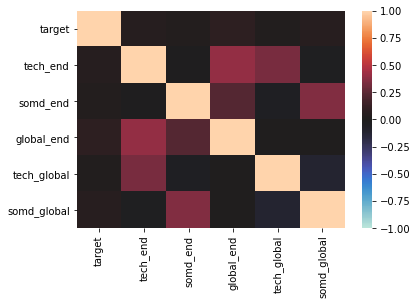

In [70]:
tech_end = [df_arrange.loc[i,"is_weekend"]*df_arrange.loc[i,"data_channel_is_tech"] for i in range(len(df_arrange))]
somd_end = [df_arrange.loc[i,"is_weekend"]*df_arrange.loc[i,"data_channel_is_socmed"] for i in range(len(df_arrange))]
global_end = [df_arrange.loc[i,"is_weekend"]*df_arrange.loc[i,"global_subjectivity"] for i in range(len(df_arrange))]
tech_global = [df_arrange.loc[i,"data_channel_is_tech"]*df_arrange.loc[i,"global_subjectivity"] for i in range(len(df_arrange))]
somd_global = [df_arrange.loc[i,"data_channel_is_socmed"]*df_arrange.loc[i,"global_subjectivity"] for i in range(len(df_arrange))]

df_arrange["tech_end"] = tech_end
df_arrange["somd_end"] = somd_end
df_arrange["global_end"] = global_end
df_arrange["tech_global"] = tech_global
df_arrange["somd_global"] = somd_global

a = df_arrange.loc[:, "target":"somd_global"]

sns.heatmap(a.corr(), vmax=1, vmin=-1, center=0)
corr_df = a.corr()
corr_df.to_clipboard()



In [34]:
#　回帰
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

x_input = df_arrange.loc[:, "n_tokens_title":"abs_title_sentiment_polarity"]
y = df_arrange[["target"]]

x_add_const = sm.add_constant(x_input)
model_sm = sm.OLS(y, x_add_const).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     63.81
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:15:04   Log-Likelihood:                -21000.
No. Observations:               39641   AIC:                         4.211e+04
Df Residuals:                   39585   BIC:                         4.259e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [17]:
df_arrange

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,target
0,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,...,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,0
1,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,...,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,0
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,1
3,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,...,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,0
4,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,...,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39636,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800,1
39637,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900,1
39638,10,442,0.516355,1.0,0.644128,24,1,12,1,5.076923,...,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900,1
39639,6,682,0.539493,1.0,0.692661,10,1,1,0,4.975073,...,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100,0


In [53]:
# weekend = df_arrange[df_arrange["is_weekend"] == 1]
# weekday = df_arrange[df_arrange["is_weekend"] == 0]

weekend = df_arrange[df_arrange["data_channel_is_socmed"] == 1]
weekday = df_arrange[df_arrange["data_channel_is_socmed"] == 0]

In [54]:
p_end = sum(weekend["target"])/len(weekend)
p_day = sum(weekday["target"])/len(weekday)

print(f"p_end:{p_end}")
print(f"p_day:{p_day}")

p_end:0.3581575548859234
p_day:0.23570394983654


In [25]:
sum(weekday["target"])

16078

In [23]:
# len(weekend)
len(weekday)

34451

In [55]:
p =  (sum(weekend["target"]) + sum(weekday["target"]))/(len(weekend)+len(weekday))
print(p)
z = abs(p_end - p_day)/np.sqrt(p*(1-p)*(1/len(weekend) + 1/len(weekday)))
print(z)

0.24287984662344542
13.353801500638209


In [59]:
num_none = len(df_arrange[(df_arrange["data_channel_is_lifestyle"]==0) &
                          (df_arrange["data_channel_is_entertainment"]==0) & (df_arrange["data_channel_is_bus"]==0) & (df_arrange["data_channel_is_socmed"]==0) &
                           (df_arrange["data_channel_is_tech"]==0) & (df_arrange["data_channel_is_world"]==0)])

num_none

6134

In [48]:
 x = (p_end - p_day)/np.sqrt((p_day*(1-p_day))/len(weekday))
 x

-49.09553901451559

In [128]:
# dlth = data less&equal than half
# dmth = data more than half

dlth = df_arrange[df_arrange["shares"] <= 1400]
dmth = df_arrange[df_arrange["shares"] > 1400]

# dlt75 = data less&equal than 75%, more than 50%
# dmt75 = data more than 75%

dlt75 = df_arrange[df_arrange["shares"] <= 2800]
dmt75 = df_arrange[df_arrange["shares"] > 2800]

# dlt75 = dmth[dmth["shares"] <= 2800]
# dmt75 = dmth[dmth["shares"] > 2800]

print(len(dlth)+len(dmth))

39641


### 分布確認

In [16]:
test = df_arrange[df_arrange["weekday_is_monday"] == 1]

test

print(len(test[test["target"]==1]))
print(len(test[test["target"]==0]))


3140
3521


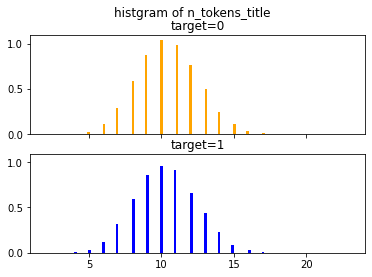

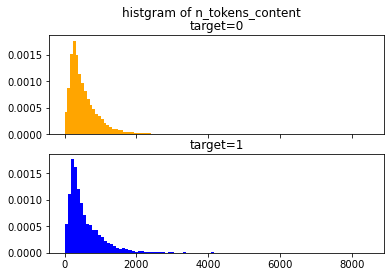

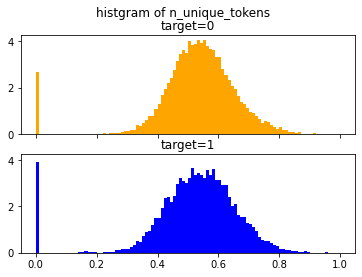

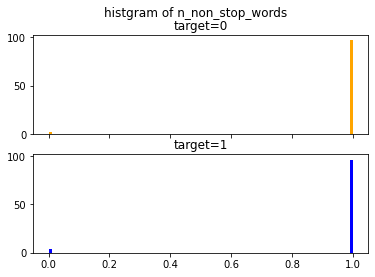

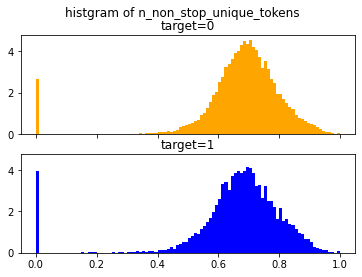

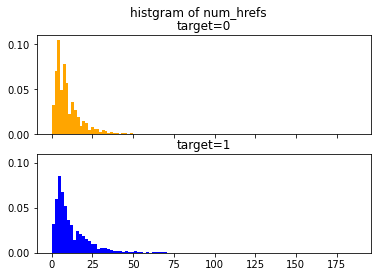

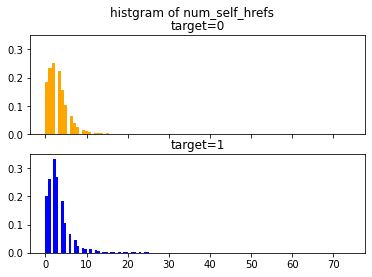

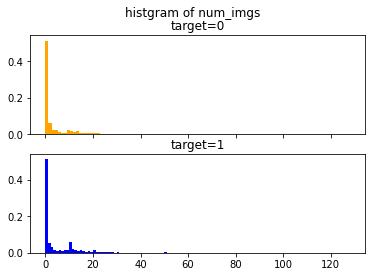

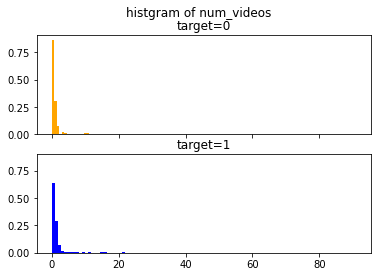

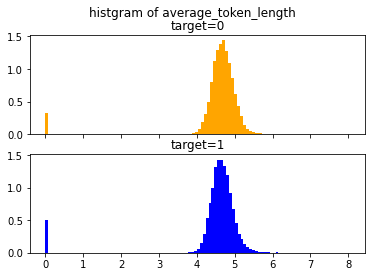

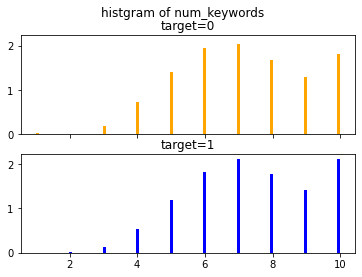

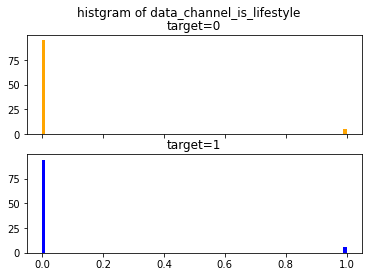

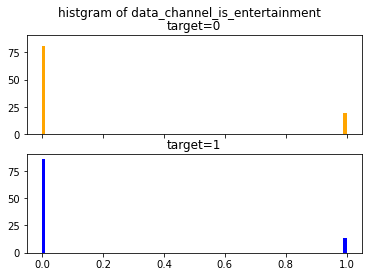

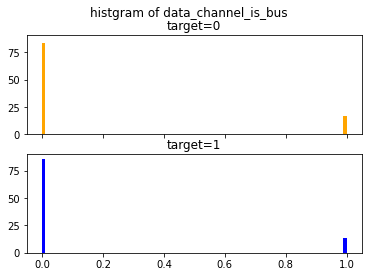

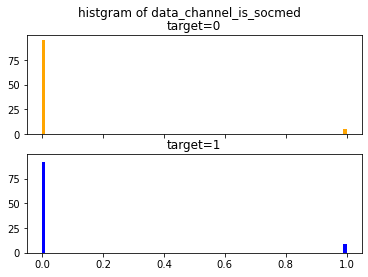

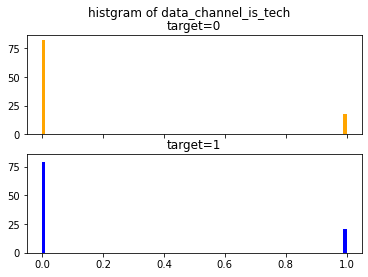

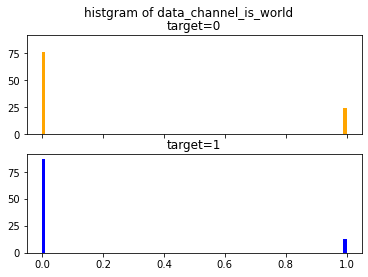

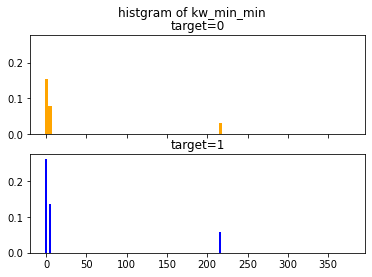

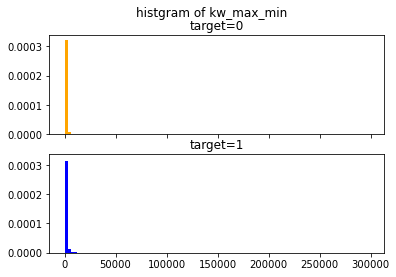

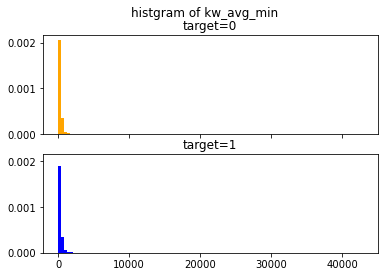

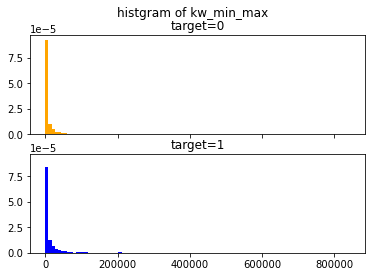

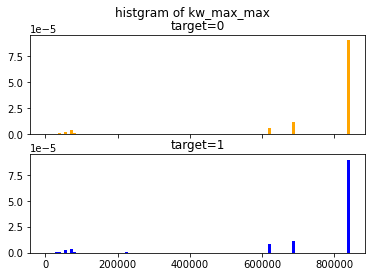

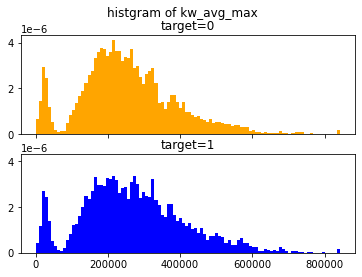

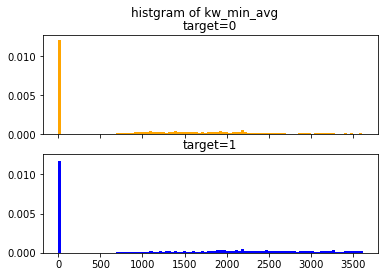

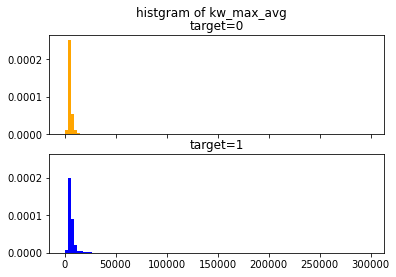

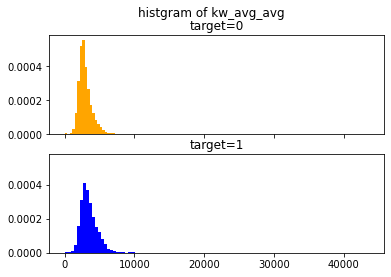

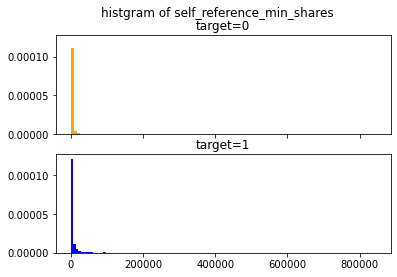

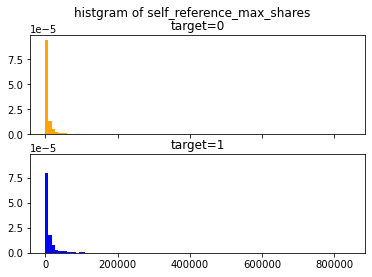

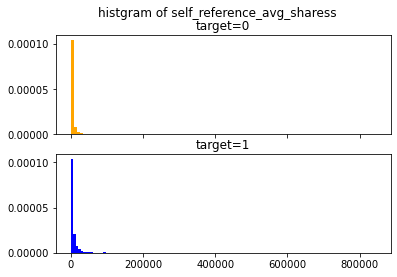

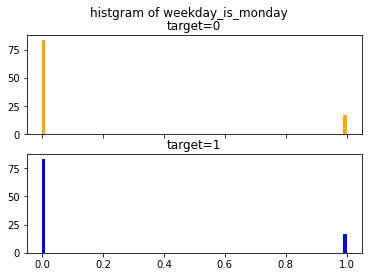

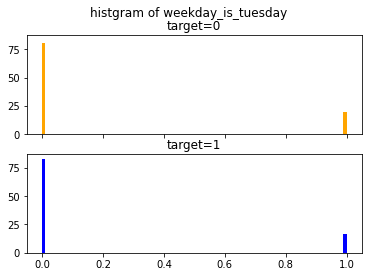

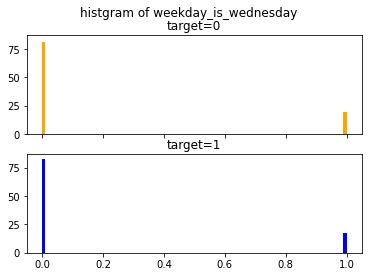

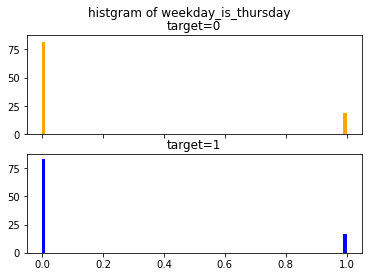

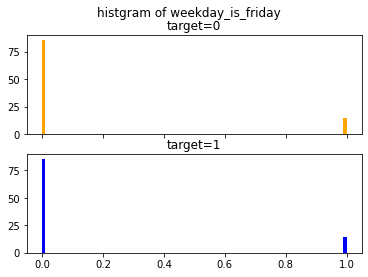

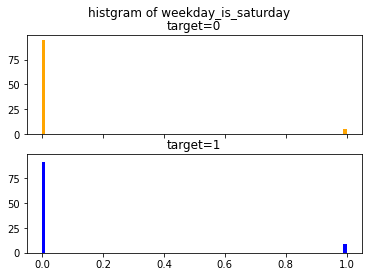

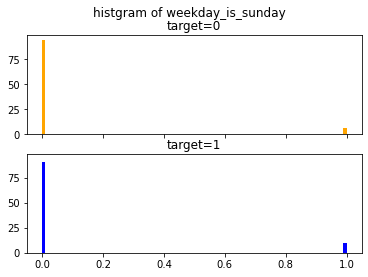

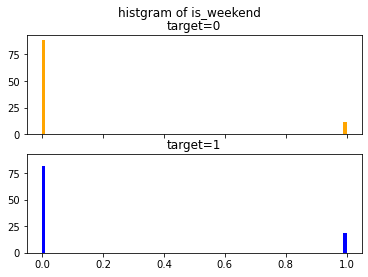

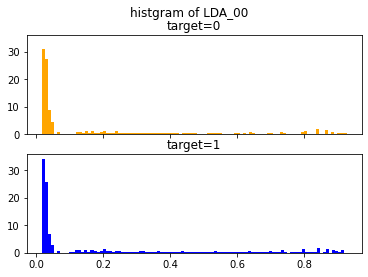

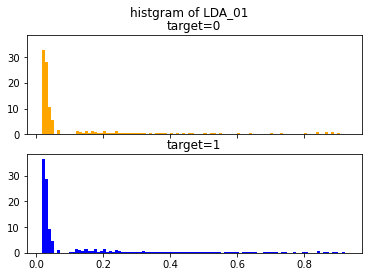

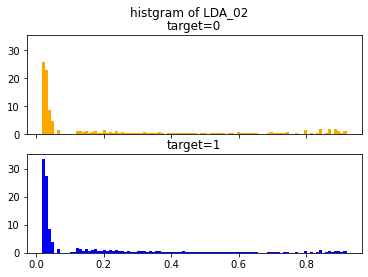

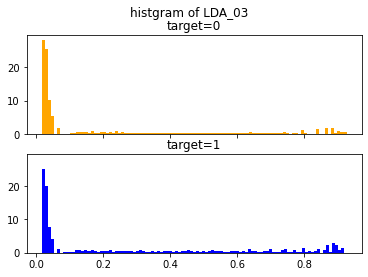

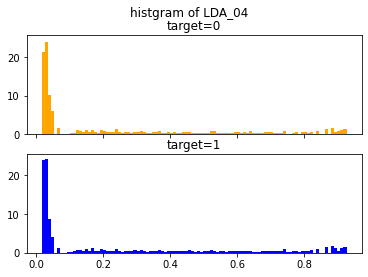

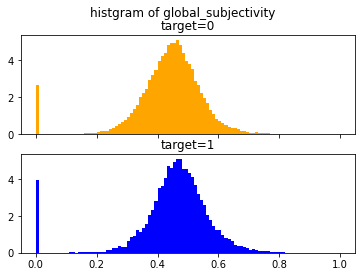

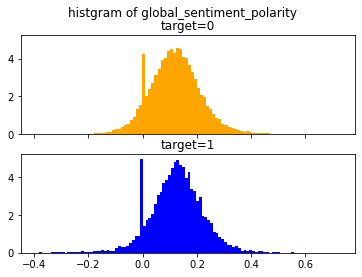

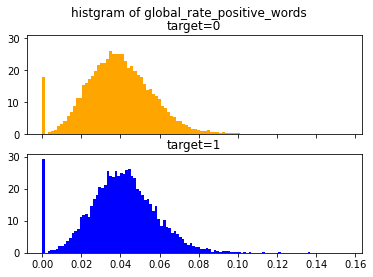

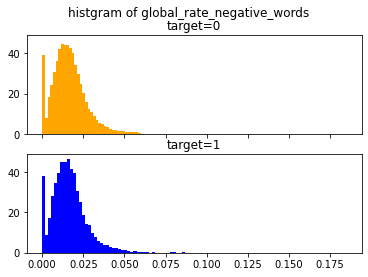

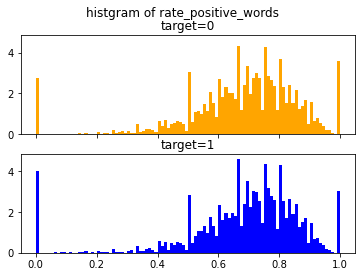

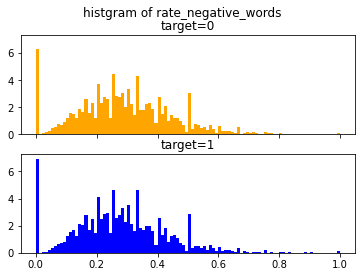

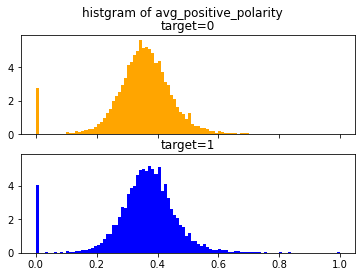

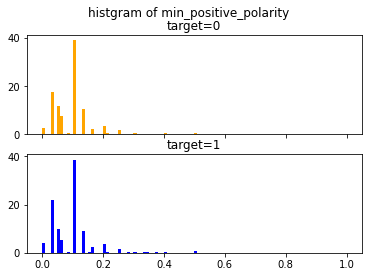

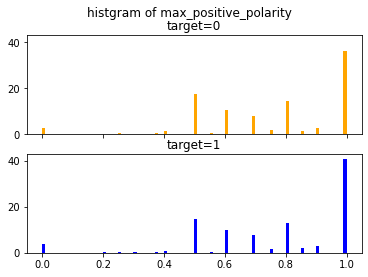

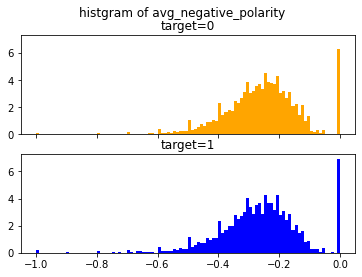

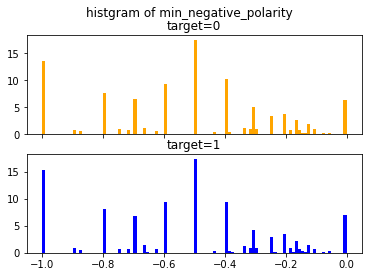

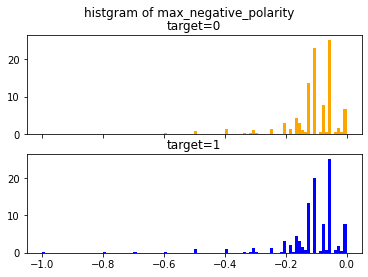

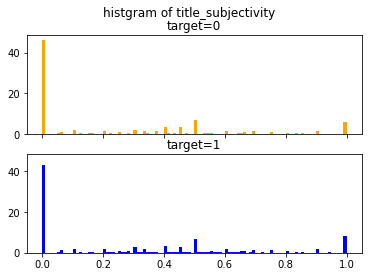

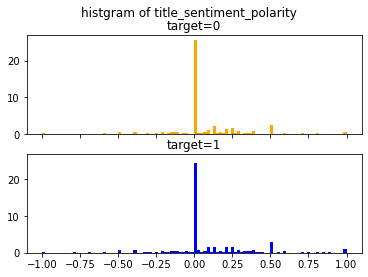

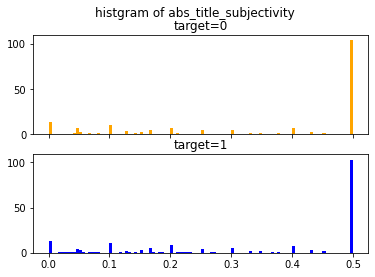

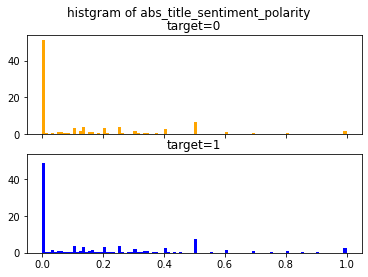

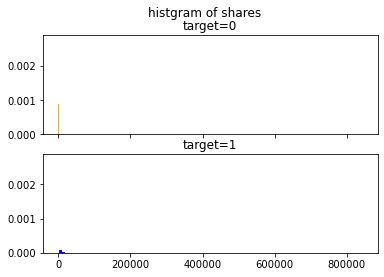

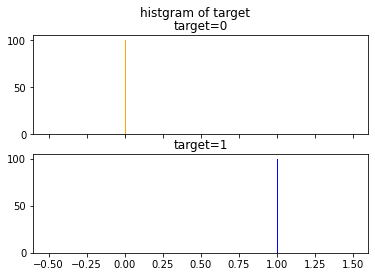

In [14]:
ipt_dt = [da0,da1]
# ipt_dt = [dlt75,dmt75]
# ipt_dt = [dlth,dmt75]

n = 0

# print(df_arrange[col_lst[n]].describe())

for n in range(len(col_lst)):

    fig , ax = plt.subplots(2,1, sharex=True, sharey=True)
    # fig.set(title=col_lst[n])
    # fig , ax = plt.subplots(2,1)

    for tar_cls, i in zip(ipt_dt, [0,1]):
        """
        st_temp = pd.DataFrame(tar_cls[col_lst[n]].describe())
        st_lst =[]
        st_lst.append(st_temp.loc["mean", col_lst[n]])
        st_lst.append(st_temp.loc["std", col_lst[n]])
        """
        X =np.array(tar_cls[col_lst[n]])
        # norm_pdf = stats.norm.pdf(x=X, loc=st_lst[0], scale=st_lst[1]) # 期待値=st0, 標準偏差=st1
        
        
        if i == 0:
            # plt.plot(X, norm_pdf, color="orange")
            ax[0].hist(X, bins=100, color="orange", density=True)
            ax[0].set(title='target=0')
        else:
            # plt.plot(X, norm_pdf, color="blue")
            ax[1].hist(X, bins=100, color="blue", density=True)
            ax[1].set(title='target=1')

        # plt.xlabel("確率変数X", fontsize=13)
        # plt.ylabel("確率密度pdf", fontsize=13)
    # print(f"column: {col_lst[n]}")
    plt.suptitle(f'histgram of {col_lst[n]}')
    # plt.savefig(f"check_fig/75/{col_lst[n]}.png")
    plt.show()


count    39641.000000
mean        10.398779
std          2.114102
min          2.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         23.000000
Name: n_tokens_title, dtype: float64


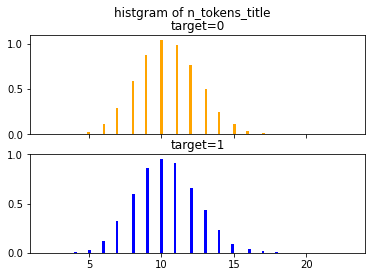

In [122]:
ipt_dt = [da0,da1]
# ipt_dt = [dlt75,dmt75]
n = 0

print(df_arrange[col_lst[n]].describe())

fig , ax = plt.subplots(2,1, sharex=True)
# fig.set(title=col_lst[n])
# fig , ax = plt.subplots(2,1)

for tar_cls, i in zip(ipt_dt, [0,1]):
    """
    st_temp = pd.DataFrame(tar_cls[col_lst[n]].describe())
    st_lst =[]
    st_lst.append(st_temp.loc["mean", col_lst[n]])
    st_lst.append(st_temp.loc["std", col_lst[n]])
    """
    X =np.array(tar_cls[col_lst[n]])
    # norm_pdf = stats.norm.pdf(x=X, loc=st_lst[0], scale=st_lst[1]) # 期待値=st0, 標準偏差=st1
    
    
    if i == 0:
        # plt.plot(X, norm_pdf, color="orange")
        ax[0].hist(X, bins=100, color="orange", density=True)
        ax[0].set(title='target=0')
    else:
        # plt.plot(X, norm_pdf, color="blue")
        ax[1].hist(X, bins=100, color="blue", density=True)
        ax[1].set(title='target=1')

    # plt.xlabel("確率変数X", fontsize=13)
    # plt.ylabel("確率密度pdf", fontsize=13)
# print(f"column: {col_lst[n]}")
plt.suptitle(f'histgram of {col_lst[n]}')
plt.savefig(f"check_fig/75/{col_lst[n]}.png")
plt.show()

#num_self_hrefs,image,video,data_channel_is_entertainment,data_channel_is_tech,data_channel_is_socmed, self_reference_max_shares, 
#self_reference_avg_sharess, weekday_is_saturday, is_weekend, avg_positive_polarity



In [111]:
da1

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,target
2,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,...,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,1
8,11,97,0.670103,1.0,0.836735,2,0,0,0,4.855670,...,0.80,-0.125000,-0.125,-0.125000,0.125000,0.000000,0.375000,0.000000,3600,1
10,9,1248,0.490050,1.0,0.731638,11,0,1,0,4.617788,...,1.00,-0.415064,-1.000,-0.100000,0.000000,0.000000,0.500000,0.000000,2200,1
11,10,187,0.666667,1.0,0.800000,7,0,1,0,4.657754,...,0.70,-0.262500,-0.400,-0.125000,0.000000,0.000000,0.500000,0.000000,1900,1
13,9,285,0.744186,1.0,0.841530,4,2,0,21,4.343860,...,1.00,-0.337889,-0.700,-0.100000,1.000000,-1.000000,0.500000,1.000000,10000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39630,9,614,0.476033,1.0,0.614987,10,0,1,0,5.094463,...,0.80,-0.181313,-0.300,-0.050000,0.000000,0.000000,0.500000,0.000000,1500,1
39633,8,2509,0.348878,1.0,0.464923,23,1,10,0,4.569550,...,1.00,-0.231612,-0.600,-0.050000,0.000000,0.000000,0.500000,0.000000,1700,1
39636,11,346,0.529052,1.0,0.684783,9,7,1,1,4.523121,...,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800,1
39637,12,328,0.696296,1.0,0.885057,9,7,3,48,4.405488,...,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900,1
